In [1]:
import pandas as pd
import numpy as np
import warnings
import statistics

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn import set_config

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

%matplotlib inline

set_config(display='diagram')

In [2]:
df_all = pd.read_csv('../data/processed/0.3-feature-processing.csv', parse_dates=['date'], index_col=0)
df = df_all[df_all['year'] > 1959]
df = df.sort_values(by=['date']).reset_index(drop=True)
df = df.set_index('driverRef', append=True)
df = df.set_index('finished', append=True)

In [3]:
#The dates of the last 5 races of Season 2021
race_rounds_dates = {
    18: datetime(2021,11,7),
    19: datetime(2021,11,14),
    20: datetime(2021,11,21),
    21: datetime(2021,12,5),
    22: datetime(2021,12,12),
}

#Return Train/test split based on a race date (exclusive)
def splitByRaceDate(race_date):
    df_train = df.loc[df['date'] < race_date]
    df_test = df.loc[df['date'] >= race_date]

    X_train = df_train[df_train.columns.difference(['positionOrder', 'date', 'round', 'year'])]
    X_test = df_test[df_test.columns.difference(['positionOrder'])]

    y_train = df_train['positionOrder']
    y_test = df_test[['positionOrder','round']]

    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = splitByRaceDate(race_rounds_dates[18])

In [5]:
len(X_train)

23305

As ridge regression is used no need to drop first column of one-hot encoding

In [6]:
one_hot_encoder = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop=None, handle_unknown='ignore'), ['circuitId'])], remainder='passthrough')

**Make costume scoring function**

In [7]:
def mseScorer(y_true, y_pred):
    y_rank = pd.DataFrame(y_pred).rank(method='first')
    return mean_squared_error(y_true=y_true, y_pred=y_rank)
    
mse_scorer = make_scorer(mseScorer, greater_is_better=False)

In [8]:
def noRetirementsScorer(y_true, y_pred):
    y_true = y_true.reset_index()
    y_rank = pd.DataFrame(y_pred).rank(method='first')
    y_concat = pd.concat([y_true, y_rank], axis=1)
    #print(y_concat.head(20))
    y_concat = y_concat[y_concat['finished'] == True]
    y_final = y_concat.iloc[:,-2:]
    y_final['rank_pred'] = y_final[y_final.columns[1]].rank(method='first')
    return mean_squared_error(y_true=y_final['positionOrder'], y_pred=y_final['rank_pred'])

no_retirements_scorer = make_scorer(noRetirementsScorer, greater_is_better=False)

In [9]:
def gridstartScorer(y_true, y_pred):
    y_concat = pd.concat([y_pred, y_true], axis=1, ignore_index=True)
    y_concat = y_concat.rename(columns={0:'y_pred',1:'y_true'})
    y_concat = y_concat.reset_index(level='finished')
    y_concat = y_concat[y_concat.finished == True]
    y_concat['pred_rank'] = y_concat['y_pred'].rank(method='first')
    return mean_squared_error(y_true=y_concat['y_true'],y_pred=y_concat['pred_rank'])

In [10]:
tscv = TimeSeriesSplit(n_splits=55, test_size=20)

In [11]:
def calculateGridstartScore(tscv):
    mse_scores = []
    for _, test_index in tscv.split(X_train):
        X_test_cv = X_train.iloc[test_index]
        y_test_cv = y_train.iloc[test_index]
        score = gridstartScorer(y_test_cv, X_test_cv['gridStart'])
        mse_scores.append(score)

    return (statistics.mean(mse_scores), mse_scores)

In [12]:
mean_mse_scores, mse_scores = calculateGridstartScore(tscv)
print('Gridstart baseline score: ', mean_mse_scores)

Gridstart baseline score:  12.421248816542935


In [13]:
def gridSearchCV_results(X_train, y_train, cv, scorer, pipeline, param_grid, output):
    model = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        cv=cv,
        n_jobs=-1,
        scoring=scorer,
        verbose=1
    )
    model.fit(X_train,y_train)
    if output:
        print('Best parameters:\n', model.best_params_)
        print('Best mean accuracy score in cross-validation:\n', abs(model.best_score_))
    return model.best_estimator_, model.cv_results_

### Ridge regression

In [14]:
ridge_pipeline = Pipeline([
    ('one_hot', one_hot_encoder),
    ('model', Ridge(random_state=42))
])
ridge_param_grid = {
    'model__alpha':[0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1],
}
#pipeline.get_params()

In [15]:
ridgeRegression_model, ridge_cv_results = gridSearchCV_results(X_train, y_train, tscv, no_retirements_scorer, ridge_pipeline, ridge_param_grid, output=True)

Fitting 55 folds for each of 12 candidates, totalling 660 fits
Best parameters:
 {'model__alpha': 0.01}
Best mean accuracy score in cross-validation:
 11.385342303035804


In [16]:
ridge_cv_results_df = pd.DataFrame(ridge_cv_results)
best_score_cv = ridge_cv_results_df.loc[ridge_cv_results_df['rank_test_score'] == 1]

best_score_cv_array = best_score_cv.iloc[:,6:-3].values

In [17]:
best_score_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,mean_test_score,std_test_score,rank_test_score
2,0.049415,0.008996,0.006185,0.003025,0.01,{'model__alpha': 0.01},-6.823529,-5.125,-7.333333,-2.5,...,-13.846154,-4.6,-6.888889,-8.4,-16.421053,-18.7,-2.941176,-11.385342,7.873358,1


In [18]:
x = np.absolute(best_score_cv_array)
y = list(x.flatten())

In [19]:
print('Model cv mean: ', np.mean(y))
print('Model cv std: ', np.std(y))

print('Baseline cv mean: ', np.mean(mse_scores))
print('Baseline cv std: ', np.std(mse_scores))

Model cv mean:  11.385342303035804
Model cv std:  7.8733575811381575
Baseline cv mean:  12.421248816542935
Baseline cv std:  9.01221419084654


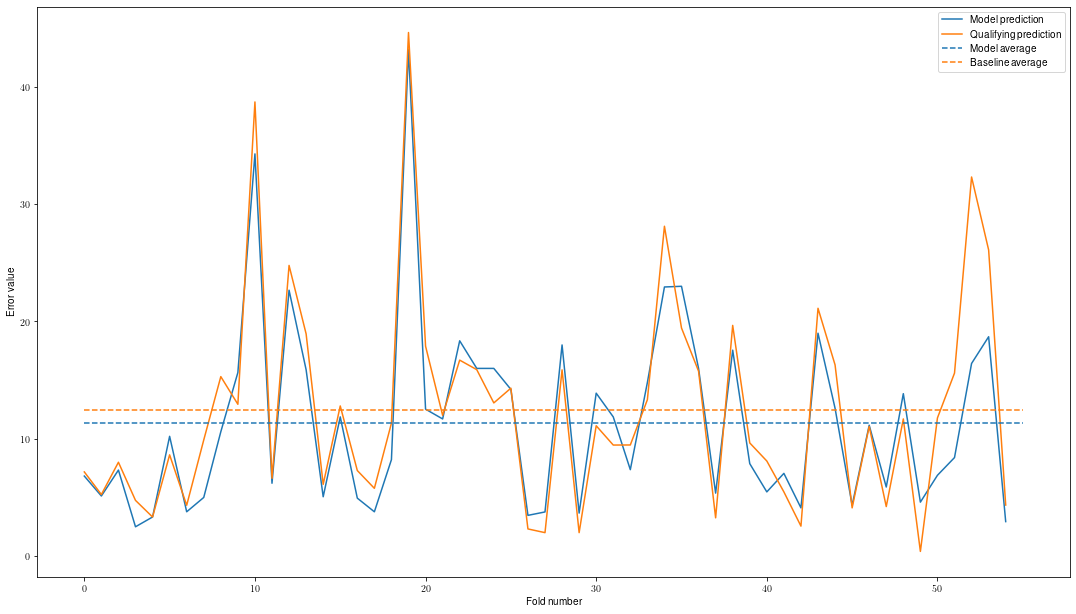

In [20]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)

ax.plot(y, label='Model prediction')
ax.plot(mse_scores, label='Qualifying prediction')

ax.hlines(np.mean(y), xmin = 0, xmax= 55, colors='tab:blue', linestyles='dashed', label='Model average')
ax.hlines(np.mean(mse_scores), xmin = 0, xmax= 55, colors='tab:orange', linestyles='dashed', label='Baseline average')

plt.xlabel('Fold number')
plt.ylabel('Error value')

plt.legend(loc="upper right")

### Random Forest regressor

In [21]:
# random_forest_pipeline = Pipeline([
#     ('one_hot', one_hot_encoder),
#     ('scaler', StandardScaler()),
#     ('model', RandomForestRegressor(random_state=42))
# ])

# random_forest_param_grid = {
#     'scaler':['passthrough', StandardScaler(with_mean=False)],
#     'model__max_depth':[5,8,10,None],
#     'model__min_samples_split':[2,3,4],
#     'model__min_samples_leaf': [2,3,4],
#     'model__n_estimators':[200],
#     'model__max_features':['auto'],
# },

# random_forest_model = gridSearchCV_results(X_train, y_train, tscv, no_retirements_scorer, random_forest_pipeline, random_forest_param_grid, output=True)

## Test on 5 last races of 2021 season

In [22]:
def createResultsTable(X_test, y_pred, y_test, round):
    X_test = X_test.reset_index()
    # X_test = X_test.reset_index(level=['finished'])
    #X_test = X_test.reset_index(drop=True)

    df_results = pd.concat([X_test[['driverRef','finished','gridStart']], pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)

    df_results['rank_pred'] = df_results['y_pred'].rank(method='first').astype(int)
    df_results = df_results.drop('y_pred', axis=1)

    y_test = y_test.reset_index(level=['driverRef'])

    final_result = pd.merge(df_results, y_test[['driverRef','positionOrder']], on=['driverRef'])
    final_result = final_result.rename(columns={'positionOrder':'rank_true'})
    #final_result['y_pred'] = final_result['y_pred'].round(2)

    final_result = final_result.sort_values(by=['gridStart'])
    final_result['round'] = round
    return final_result

In [23]:
df_every_round_results = pd.DataFrame()
mse_results = []

model = ridgeRegression_model

for round, date in race_rounds_dates.items():
    X_train, X_test, y_train, y_test = splitByRaceDate(date)
    model.fit(X_train, y_train)
    
    X_test_current_round = X_test.loc[X_test['round'] == round]
    y_pred_current_round = model.predict(X_test_current_round)
    y_test_current_round = y_test.loc[y_test['round'] == round]

    df_results = createResultsTable(X_test_current_round, y_pred_current_round, y_test_current_round, round)
    df_every_round_results = df_every_round_results.append(df_results)

    model_mse = noRetirementsScorer(y_true=y_test_current_round.iloc[:,:-1], y_pred=y_pred_current_round)
    grid_start_mse = noRetirementsScorer(y_true=y_test_current_round.iloc[:,:-1], y_pred=X_test_current_round['gridStart'].to_numpy())
    #model_mse =  noRetirementsScorer(y_true=df_results['rank_true'], y_pred=df_results['rank_pred'])
    #grid_start_mse = noRetirementsScorer(y_true=df_results['rank_true'], y_pred=df_results['gridStart'])

    mse_results.append([round, model_mse, grid_start_mse])

mse_results = pd.DataFrame(mse_results, columns=['round', 'model_mse', 'grid_start_mse'])

In [24]:
mse_results

,round,model_mse,grid_start_mse
0,18,21.000000,19.666667
1,19,6.111111,10.222222
2,20,10.000000,14.555556
3,21,9.600000,12.000000
4,22,20.500000,15.875000


In [25]:
df_every_round_results.reset_index(drop=True)

,driverRef,finished,gridStart,rank_pred,rank_true,round
0,bottas,True,1,2,15,18
1,hamilton,True,2,1,2,18
2,max_verstappen,True,3,3,1,18
3,perez,True,4,4,3,18
4,gasly,True,5,11,4,18
...,...,...,...,...,...,...
95,latifi,False,16,17,16,22
96,russell,False,17,18,18,22
97,raikkonen,False,18,15,19,22
98,mick_schumacher,True,19,19,14,22


In [26]:
df_every_round_results.to_csv('../data/processed/0.4-test_results.csv', index=False)